In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import scvelo as scv
scv.settings.verbosity=1

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
from utils import *

In [2]:
# paths
at_home = False if '/fast/work/users/' in os.getcwd() else True
data_path = '/extra/stefan/data/perturbation_resource_paper/' if at_home else '/fast/work/users/peidlis_c/data/perturbation_resource_paper/'
signatures_path = '/home/peidli/utils/scrnaseq_signature_collection/' if at_home else '/fast/work/users/peidlis_c/utils/scrnaseq_signature_collection/'
utils_path = '/extra/stefan/utils/scrnaseq_utils/' if at_home else '/fast/work/users/peidlis_c/utils/single_cell_rna_seq/scrnaseq_utils/'

# Stefan's utils
sys.path.insert(1, utils_path)
from scrnaseq_util_functions import *

# Load data

In [13]:
h5_files = {}
for path, subdirs, files in os.walk(data_path):
    for name in files:
        if '.h5' in name and 'scATAC' not in name: h5_files[name[:-3]] = os.path.join(path, name)
del h5_files['exampledataset']
del h5_files['NormanWeissman2019_raw']
del h5_files['PapalexiSatija2021_eccite_arrayed_protein']
del h5_files['PapalexiSatija2021_eccite_protein']
del h5_files['FrangiehIzar2021_protein']
del h5_files['gene_scores']
del h5_files['peak_bc']
del h5_files['ChromVar']
del h5_files['LSI_embedding']
del h5_files['markerpeak_target']
print(len(h5_files))
list(h5_files.keys())

32


['PapalexiSatija2021_eccite_arrayed_RNA',
 'PapalexiSatija2021_eccite_RNA',
 'TianKampmann2021_CRISPRa',
 'TianKampmann2021_CRISPRi',
 'XieHon2017',
 'AissaBenevolenskaya2021',
 'McFarlandTshemiak2020_all_expts_combined',
 'GasperiniShendure2019_lowMOI',
 'GasperiniShendure2019_atscale',
 'GasperiniShendure2019_highMOI',
 'ZhaoSims2021',
 'DixitRegev2016',
 'DatlingerBock2017',
 'DatlingerBock2021',
 'FrangiehIzar2021_RNA',
 'WeinrebKlein2020',
 'ShifrutMarson2018',
 'K562_essential.h',
 'ChangYe2021',
 'SchiebingerLander2019_GSE115943',
 'SchiebingerLander2019_GSE106340',
 'NormanWeissman2019_filtered',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_11_screen',
 'SchraivogelSteinmetz2020_TAP_SCREEN__chromosome_8_screen',
 'AdamsonWeissman2016_GSM2406677_10X005',
 'AdamsonWeissman2016_GSM2406681_10X010',
 'AdamsonWeissman2016_GSM2406675_10X001',
 'SrivatsanTrapnell2020_sciplex2',
 'SrivatsanTrapnell2020_sciplex3',
 'SrivatsanTrapnell2020_sciplex4',
 'TianKampmann2019_day7neuron',
 '

In [14]:
obses = {}
vares = {}
for name, path in tqdm(h5_files.items()):
    try:
        obses[name] = pd.read_csv(os.path.dirname(path)+'/obs.csv', index_col=0)
        vares[name] = pd.read_csv(os.path.dirname(path)+'/var.csv', index_col=0)
    except:
        print(f'Annotation failed for {name}.')


 53%|█████▎    | 17/32 [00:07<00:04,  3.15it/s]

Annotation failed for K562_essential.h.


100%|██████████| 32/32 [00:13<00:00,  2.38it/s]


In [15]:
metadata = pd.read_csv('../../tables/publicly_available_singlecell_perturbation_data_24032022.csv', index_col=0)
metadata.keys()

Index(['Title', 'doi/url', 'First author', 'Selected other authors',
       'Corresponding Emails', 'Organisms', 'Modality = Data type', 'Method',
       'Sequencer', 'Library construction', 'data access', 'GSE', 'Tissues',
       'Perturbation', 'Leukemia', 'Solid Cancer', 'Notes',
       '# samples, cells or runs', 'multiple time points?',
       'multiple concentrations?', 'combined perturbations?',
       'Date of Submission', 'sgRNA library', 'Download status',
       'Mini-Abstract (loosely summarized original Abstract)'],
      dtype='object')

# Num

In [18]:
df = obses[list(obses.keys())[0]]

<AxesSubplot:ylabel='ncounts'>

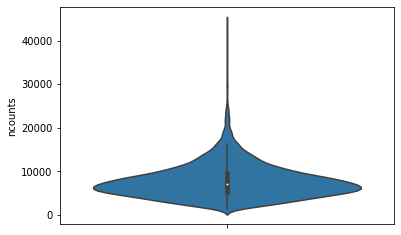

In [22]:
sns.violinplot(data=df, y='ncounts')

In [38]:
entries = {}
feats = ['ncounts', 'ngenes']
for key in tqdm(obses.keys()):
    df = obses[key]
    try:
        entries[key] = [np.mean(df[f]) for f in feats]
    except:
        pass

100%|██████████| 31/31 [00:00<00:00, 1722.71it/s]


In [39]:
res = pd.DataFrame(entries, index=feats).T
res

,ncounts,ngenes
PapalexiSatija2021_eccite_arrayed_RNA,7767.093500,2554.936776
PapalexiSatija2021_eccite_RNA,13259.987119,3354.192146
TianKampmann2021_CRISPRa,10910.682584,3476.868022
TianKampmann2021_CRISPRi,14820.948266,4431.089443
XieHon2017,88739.620492,3442.310096
McFarlandTshemiak2020_all_expts_combined,22159.952612,3889.984093
GasperiniShendure2019_lowMOI,22108.307698,3755.207175
GasperiniShendure2019_atscale,18171.176834,3371.526268
GasperiniShendure2019_highMOI,19305.300147,3675.874334
ZhaoSims2021,3358.898068,1473.238139


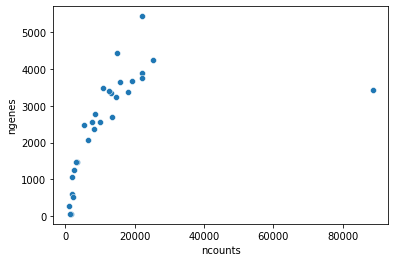

In [41]:
sns.scatterplot(data=res, x='ncounts', y='ngenes')
pl.show()

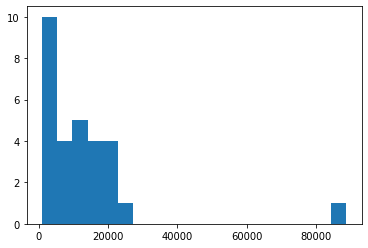

In [45]:
pl.hist(res.ncounts, bins=20)
pl.show()